In [91]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import copy
import networkx as nx
from collections import Counter
import numpy as np
import json
import powerlaw

In [92]:
df_trec = pd.read_parquet("../data/Network_preparations_TREC.parquet")
df_ceur = pd.read_parquet("../data/Network_preparations_CEUR.parquet")
df_lncs = pd.read_parquet("../data/Network_preparations_LNCS.parquet")

# Calculate the Coverage gain by using GROBID

In [93]:
def calculate_coverage_gain_grobid(df):
    counter = 0
    for i, j in df.iterrows():
        if len(j["Countries"]) == 0 and len(j["grobid"]) == 0 :
            counter += 1
    cov_perc = (len(df) - counter) / len(df)
    return cov_perc
    

In [94]:
print(calculate_coverage_gain_grobid(df_trec))

0.8


In [95]:
print(calculate_coverage_gain_grobid(df_ceur))

0.8299510146955913


In [96]:
print(calculate_coverage_gain_grobid(df_lncs))

0.9640816326530612


# Analysis of the German IR Community

In [97]:
df_trec["Proceeding"] = "TREC"
df_lncs["Proceeding"] = "LNCS"
df_ceur["Proceeding"] = "CEUR"

In [98]:
df_german = pd.concat([df_ceur, df_lncs, df_trec], axis=0).reset_index(drop=True)

In [100]:
# Manually created list of all variations of Germany occuring in the data

concordance_list = ["Germany", 'Germany, Germany', "Germany (", "GERMANY", "Germany [", "Germany, www", "Canada), UK) IAI (Germany" ]

In [101]:
# Filter documents by participating institutions from Germany 
german_participation = []
for i, j in df_german.iterrows():
    for k in j["Countries"]:
        if k[0] in concordance_list:
            if i not in german_participation:
                german_participation.append(i)
    for k in j["grobid"]:
        if k[0] in concordance_list:
            if i not in german_participation:
                german_participation.append(i)

In [102]:
df_german = df_german.loc[german_participation]

In [103]:
# Reading dictionary that contains all name variations of the given german institutes in order to unify the institute names

with open('../data/reassigning_institutes_dict.json', 'r') as json_file:
    inst_reassigment_dict = json.load(json_file)

In [104]:
# Reading dictionary that contains all name variations of the given authors that are associated with a german institutes in order to unify the author names

with open('../data/reassigning_authors_dict.json', 'r') as json_file:
    auth_reassigment_dict = json.load(json_file)

In [105]:
# Apply the concordance dicts to unify author names

def replace_in_nested_arrays(nested_arrays, replacement_dict):
    # Iterate over each array in the nested arrays
    for outer_array in nested_arrays:
        # Look through each element in the individual sub-array
        for i, element in enumerate(outer_array):
            for key, value_list in replacement_dict.items():
                # Check each key-value pair in the dictionary
                if element in value_list:
                    # Replace the matched element with the corresponding key
                    outer_array[i] = key
                    break

    return nested_arrays

# Apply the function to the DataFrame column
df_german['grobid_new'] = df_german['grobid'].apply(lambda x: replace_in_nested_arrays(copy.deepcopy(x), auth_reassigment_dict))
df_german['Countries_new'] = df_german['Countries'].apply(lambda x: replace_in_nested_arrays(copy.deepcopy(x), auth_reassigment_dict))

In [106]:
# Extract the german institutes from the DataFrame based on the concordance_list
german_institutes_full = []

for i, row in df_german.iterrows():
    german_institutes = []
    for sublist in row["Countries_new"]:
        if sublist[0] in concordance_list:
            if sublist[1] not in german_institutes:
                german_institutes.append(sublist[1])
    for sublist in row["grobid_new"]:
        if sublist[0] in concordance_list:
            if sublist[1] not in german_institutes:
                german_institutes.append(sublist[1])

    german_institutes_full.append(german_institutes)

In [107]:
df_german["German Institutes"] = german_institutes_full

In [108]:
def transform_and_deduplicate(institute_list, replacement_dict):
    # Create a new list with replaced values
    transformed_list = [
        next((key for key, value_list in replacement_dict.items() if institute in value_list), institute)
        for institute in institute_list
    ]
    # Remove duplicates by converting the list to a set and back to a list
    return list(set(transformed_list))

# Apply the function to the column
df_german['Processed Institutes'] = df_german['German Institutes'].apply(lambda x: transform_and_deduplicate(x, inst_reassigment_dict))

In [109]:
def process_dataframe(df, inst_reassignment_dict):
    # Add 'Processed Institutes' column
    df['Processed Institutes'] = df['German Institutes'].apply(lambda x: transform_and_deduplicate(x, inst_reassignment_dict))
    df['PubYear'] = df['PubYear'].astype(int)

    # Explode DataFrame and create pivot table
    df_exploded = df.explode('Processed Institutes')
    pivot_df = df_exploded.groupby(['Processed Institutes', 'Proceeding']).size().unstack(fill_value=0)
    pivot_df['Total'] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values("Total", ascending=False)
    
    # Calculate amount of unique authors
    amount_authors = []
    for _, row in df.iterrows():
        unique_authors = set()
        for k in row["Countries_new"]:
            unique_authors.add(k[2])
        for l in row["grobid_new"]:
            unique_authors.add(l[2])
        amount_authors.append(len(unique_authors))
    df["Amount Authors"] = amount_authors
    
    # Create stats DataFrame
    df_exploded = df.explode("Processed Institutes")
    stats_df = df_exploded.groupby('Processed Institutes').agg(
        min_amount=('Amount Authors', 'min'),
        max_amount=('Amount Authors', 'max'),
        avg_amount=('Amount Authors', 'mean')
    ).reset_index()
    
    # Filter stats_df to match the indices of pivot_df
    stats_df = stats_df[stats_df["Processed Institutes"].isin(list(pivot_df.index))]
    stats_df = stats_df.set_index('Processed Institutes').reindex(list(pivot_df.index)).reset_index()
    
    return pivot_df, stats_df

def filter_and_process_dataframe(df, inst_reassignment_dict, condition="all"):
    results = {}
    if condition == "all":
        pivot_df, stats_df = process_dataframe(df, inst_reassignment_dict)
        print("Top 20 entries for 'all':")
        print(pivot_df.head(20))
        print(stats_df.head(20))
        results['all'] = (pivot_df, stats_df)
    else:
        intervals = {
            "2000-2004": (2000, 2004),
            "2005-2009": (2005, 2009),
            "2010-2014": (2010, 2014),
            "2015-2022": (2015, 2022)
        }
        
        for key, (start_year, end_year) in intervals.items():
            filtered_df = df[(df['PubYear'] >= start_year) & (df['PubYear'] <= end_year)]
            pivot_df, stats_df = process_dataframe(filtered_df, inst_reassignment_dict)
            print(f"Top 5 entries for '{key}':")
            print(pivot_df.head(5))
            print(stats_df.head(5))
            results[key] = (pivot_df, stats_df)
    
    return results

In [110]:
results = filter_and_process_dataframe(df_german, inst_reassigment_dict, "all")

Top 20 entries for 'all':
Proceeding                                          CEUR  LNCS  TREC  Total
Processed Institutes                                                       
University of Hildesheim                              31    29     0     60
University of Hagen                                   23    20     0     43
MLT-Lab DFKI                                          21    16     2     39
Bauhaus-Universität Weimar                            11    15    10     36
Technische Unversität Chemnitz                        22    13     0     35
RWTH Computer Science Department                      17    17     0     34
Universität Leipzig                                   19    13     1     33
Fraunhofer Society                                    21     4     6     31
Humboldt University Berlin                            10    11     0     21
GESIS - Leibniz-Institute for the Social Sciences      9     8     3     20
Saarland University                                    5     7

In [87]:
results = filter_and_process_dataframe(df_german, inst_reassigment_dict, "intervals")

Top 5 entries for '2000-2004':
Proceeding                                CEUR  LNCS  TREC  Total
Processed Institutes                                             
University of Hildesheim                     6     6     0     12
MLT-Lab DFKI                                 3     2     1      6
University of Hagen                          3     3     0      6
RWTH Computer Science Department             2     1     0      3
Informationszentrum Sozialwissenschaften     0     2     0      2
                       Processed Institutes  min_amount  max_amount  \
0                  University of Hildesheim           1           6   
1                              MLT-Lab DFKI           2           8   
2                       University of Hagen           1           2   
3          RWTH Computer Science Department           1           3   
4  Informationszentrum Sozialwissenschaften           1           7   

   avg_amount  
0    3.083333  
1    3.000000  
2    1.333333  
3    2.333333  


/tmp/ipykernel_3974/3224999380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Processed Institutes'] = df['German Institutes'].apply(lambda x: transform_and_deduplicate(x, inst_reassignment_dict))
/tmp/ipykernel_3974/3224999380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PubYear'] = df['PubYear'].astype(int)
/tmp/ipykernel_3974/3224999380.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

# Betweeness centrality Preparations (for Authors)

In [111]:
# Create a list of all participating authors within the documents that have at least one german participating institute

authors_complete = []
for i, j in df_german.iterrows():
    authors = []
    for k in j["Countries_new"]:
        if k[2] not in authors:
            authors.append(k[2])
    for k in j["grobid_new"]:
        if k[2] not in authors:
            authors.append(k[2])
    authors_complete.append(authors)

In [112]:
df_german["authors_all"] = authors_complete

In [113]:
def process_dataframe(df, concordance_list):
    # Identify all authors that contributed in the papers
    authors_complete = []
    for _, j in df.iterrows():
        authors = []
        for k in j["Countries_new"]:
            if k[2] not in authors:
                authors.append(k[2])
        for k in j["grobid_new"]:
            if k[2] not in authors:
                authors.append(k[2])
        authors_complete.append(authors)
    df["authors_all"] = authors_complete

    # Identify all authors, that worked for a german institution within the timeframes of the data
    german_authors_complete = []
    for _, row in df.iterrows():
        for k in row["Countries_new"]:
            if k[0] in concordance_list and k[2] not in german_authors_complete:
                german_authors_complete.append(k[2])
        for k in row["grobid_new"]:
            if k[0] in concordance_list and k[2] not in german_authors_complete:
                german_authors_complete.append(k[2])
    
    # Delete wrongly assigned authors
    to_remove = ["Petya Osenova", "Giorgio Maria Di Nunzio"]
    for author in to_remove:
        if author in german_authors_complete:
            german_authors_complete.remove(author)

    german_authors_complete = [author for author in german_authors_complete if author.strip()]

    # Create the network graph for calulating the betweenness centrality
    G = nx.DiGraph()
    for paper in authors_complete:
        for i, author1 in enumerate(paper):
            for author2 in paper[i+1:]:
                G.add_edge(author1, author2)

    betweenness_centrality = nx.betweenness_centrality(G)

    # DataFrame für Zwischenzentralität erstellen
    node_centrality_pairs = [[node, centrality] for node, centrality in betweenness_centrality.items()]
    df_betweeness = pd.DataFrame(node_centrality_pairs, columns=["Authors", "Betweeness"])
    df_betweeness = df_betweeness[df_betweeness["Authors"].isin(german_authors_complete)]
    df_betweeness = df_betweeness.sort_values("Betweeness", ascending=False)

    # Calculate the amount of papers per author in the different proceedings
    amount_papers = []
    for author in df_betweeness["Authors"]:
        counter_trec = counter_lncs = counter_ceur = 0
        for _, j in df.iterrows():
            if author in j["authors_all"]:
                if j["Proceeding"] == "TREC":
                    counter_trec += 1
                elif j["Proceeding"] == "LNCS":
                    counter_lncs += 1
                elif j["Proceeding"] == "CEUR":
                    counter_ceur += 1
        amount_papers.append([author, counter_trec, counter_lncs, counter_ceur, counter_trec + counter_lncs + counter_ceur])

    # Create new dataframe containing the author output in the differnt proceedings
    df_works = pd.DataFrame(amount_papers, columns=["Authors", "# TREC", "# LNCS", "# CEUR", "Total"])

    # Merging Dataframes 
    df_merge = pd.merge(df_betweeness, df_works, on="Authors")

    return df_merge

def filter_and_process_dataframe(df, concordance_list, condition="all"):
    # Convert PubYear column into integer
    df['PubYear'] = pd.to_numeric(df['PubYear'], errors='coerce')
    df = df.dropna(subset=['PubYear'])
    df['PubYear'] = df['PubYear'].astype(int)

    results = {}
    if condition == "all":
        df_merge = process_dataframe(df, concordance_list)
        print("Top 15 entries for 'all':")
        print(df_merge.head(15))
        results['all'] = df_merge
    else:
        intervals = {
            "2000-2004": (2000, 2004),
            "2005-2009": (2005, 2009),
            "2010-2014": (2010, 2014),
            "2015-2022": (2015, 2022)
        }
        
        for key, (start_year, end_year) in intervals.items():
            filtered_df = df[(df['PubYear'] >= start_year) & (df['PubYear'] <= end_year)]
            df_merge = process_dataframe(filtered_df, concordance_list)
            print(f"Top 5 entries for '{key}':")
            print(df_merge.head(5))
            results[key] = df_merge
    
    return results

In [114]:
results = filter_and_process_dataframe(df_german, concordance_list, "all")

Top 15 entries for 'all':
                  Authors  Betweeness  # TREC  # LNCS  # CEUR  Total
0            Thomas Mandl    0.074677       0      27      30     57
1             Benno Stein    0.036774       9      14      18     41
2           Vivien Petras    0.036245       0       8       5     13
3     Christoph Friedrich    0.022167       2       6      12     20
4            Diana Santos    0.020045       0       5       4      9
5   Christa Womser_Hacker    0.014107       0      16      17     33
6            Obioma Pelka    0.009408       0       3       6      9
7         Martin Potthast    0.008438       1      14      16     31
8        Bogdan Sacaleanu    0.007528       0       9       9     18
9         Maximilian Eibl    0.007440       0      12      21     33
10         Bayzidul Islam    0.006660       0       1       2      3
11        Christina Unger    0.005368       0       3       3      6
12         Matthias Hagen    0.004825       9       5       4     18
13      

In [ ]:
# Extract author names for gathering their related institutes in the next step
authors_german_institutes = results["all"].head(15)["Authors"].tolist()

In [119]:
# Dictionary zur Speicherung der Zuordnungen
author_to_value = {}

for index, row in df_german.iterrows():
    for country_list in row['Countries_new']:
        third_value = country_list[2]
        second_value = country_list[1]
        
        if third_value in authors_german_institutes:
            author_to_value[third_value] = second_value
    for country_list in row['grobid_new']:
        third_value = country_list[2]
        second_value = country_list[1]
        
        if third_value in authors_german_institutes:
            author_to_value[third_value] = second_value

print(author_to_value)

{'Maximilian Eibl': 'Technische Universität Chemnitz', 'Benno Stein': 'Bauhaus-Universität Weimar', 'Martin Potthast': 'Bauhaus-Universität Weimar', 'Thomas Mandl': 'Information Science', 'Vivien Petras': 'Berlin School of Library and Information Science', 'Christa Womser_Hacker': 'Information Science', 'Obioma Pelka': 'University of Applied Sciences and Arts Dortmund', 'Christoph Friedrich': 'Science and Arts Dortmund Department of Computer Science', 'Matthias Hagen': 'Martin Luther University Halle-Wittenberg', 'Thomas Deselaers': 'RWTH Aachen University', 'Bogdan Sacaleanu': 'LT-Lab', 'Diana Santos': 'SINTEF', 'Stefan Kahl': 'Chemnitz University of Technology', 'Christina Unger': 'CITEC', 'Bayzidul Islam': 'Technische Universität Darmstadt'}


In [120]:
author_to_value

{'Maximilian Eibl': 'Technische Universität Chemnitz',
 'Benno Stein': 'Bauhaus-Universität Weimar',
 'Martin Potthast': 'Bauhaus-Universität Weimar',
 'Thomas Mandl': 'Information Science',
 'Vivien Petras': 'Berlin School of Library and Information Science',
 'Christa Womser_Hacker': 'Information Science',
 'Obioma Pelka': 'University of Applied Sciences and Arts Dortmund',
 'Christoph Friedrich': 'Science and Arts Dortmund Department of Computer Science',
 'Matthias Hagen': 'Martin Luther University Halle-Wittenberg',
 'Thomas Deselaers': 'RWTH Aachen University',
 'Bogdan Sacaleanu': 'LT-Lab',
 'Diana Santos': 'SINTEF',
 'Stefan Kahl': 'Chemnitz University of Technology',
 'Christina Unger': 'CITEC',
 'Bayzidul Islam': 'Technische Universität Darmstadt'}

In [121]:
results = filter_and_process_dataframe(df_german, concordance_list, "intervals")

/tmp/ipykernel_3974/3662986960.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["authors_all"] = authors_complete
/tmp/ipykernel_3974/3662986960.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["authors_all"] = authors_complete


Top 5 entries for '2000-2004':
            Authors  Betweeness  # TREC  # LNCS  # CEUR  Total
0  Thomas Deselaers         0.0       0       1       1      2
1    Daniel Keysers         0.0       0       1       1      2
2    Michael Kaißer         0.0       1       0       0      1
3     Michael Kluck         0.0       0       3       0      3
4  Martín Braschler         0.0       0       2       0      2
Top 5 entries for '2005-2009':
                 Authors  Betweeness  # TREC  # LNCS  # CEUR  Total
0           Diana Santos    0.036582       0       5       4      9
1           Thomas Mandl    0.020609       0      19      19     38
2       Bogdan Sacaleanu    0.014688       0       7       7     14
3  Christa Womser_Hacker    0.007526       0       8       8     16
4       Thomas Deselaers    0.007184       0      10       9     19


/tmp/ipykernel_3974/3662986960.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["authors_all"] = authors_complete


Top 5 entries for '2010-2014':
           Authors  Betweeness  # TREC  # LNCS  # CEUR  Total
0    Vivien Petras    0.003778       0       3       2      5
1      Benno Stein    0.003048       3       2       3      8
2  Martin Potthast    0.002427       1       2       3      6
3    Julia Jürgens    0.000902       0       1       2      3
4     Thomas Mandl    0.000902       0       0       4      4


/tmp/ipykernel_3974/3662986960.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["authors_all"] = authors_complete


Top 5 entries for '2015-2022':
               Authors  Betweeness  # TREC  # LNCS  # CEUR  Total
0  Christoph Friedrich    0.005647       0       6      12     18
1       Bayzidul Islam    0.004366       0       1       2      3
2          Benno Stein    0.003773       6      11      14     31
3         Obioma Pelka    0.002504       0       3       6      9
4          Stefan Kahl    0.002460       0       1       6      7


## Comparison with Lotka's Law

In [122]:
# Extract the german authors (authors that were working for a german institute) for every document
german_authors_complete_2 = []

names_to_filter = ["Petya Osenova", "Giorgio Maria Di Nunzio"] 

for i, row in df_german.iterrows():
    authors = []
    for k in row["Countries_new"]:
        if k[0] in concordance_list:
            if k[2] not in authors and k[2] not in names_to_filter :
                authors.append(k[2])
    for k in row["grobid_new"]:
        if k[0] in concordance_list:
            if k[2] not in authors and k[2] not in names_to_filter:
                authors.append(k[2])
    german_authors_complete_2.append(authors)

print(len(german_authors_complete_2))

560


In [123]:
german_authors_complete_2

[['Mike Ebersbach', 'Robert Herms', 'Christina Lohr', 'Maximilian Eibl'],
 ['Jonas Jäger',
  'Erik Rodner',
  'Joachim Denzler',
  'Viviane Wolff',
  'Klaus Fricke_Neuderth'],
 [' '],
 ['Benjamin Kille', 'Andreas Lommatzsch', 'Jonas Seiler', 'Torben Brodt'],
 ['Alexandru Ciobanu', 'Andreas Lommatzsch'],
 ['Jaschar Domann', 'Jens Meiners', 'Lea Helmers', 'Andreas Lommatzsch'],
 ['Andreas Lommatzsch',
  'Niels Johannes',
  'Jens Meiners',
  'Lea Helmers',
  'Jaschar Domann'],
 ['Patrick Probst', 'Andreas Lommatzsch'],
 ['Jing Yuan', 'Andreas Lommatzsch', 'Benjamin Kille'],
 ['Benno Stein', 'Martin Potthast'],
 ['Martin Potthast', 'Benno Stein'],
 ['Ivan Bilan', 'Desislava Zhekova'],
 ['Matthias Liebeck', 'Pashutan Modaresi', 'Stefan Conrad'],
 ['Pashutan Modaresi', 'Matthias Liebeck', 'Stefan Conrad'],
 ['Maria Gäde'],
 ['Stefanie Nowak'],
 ['Olivier Pauly', 'Diana Mateus', 'Nassir Navab'],
 ['Andreas Nürnberger'],
 ['Philipp Sorg', 'Philipp Cimiano', 'Antje Schultz', 'Sergej Sizov'],
 [

In [124]:
df_german["German Authors all"] = german_authors_complete_2

In [125]:
df_german

,PubYear,CEUR Title,Volume,filename,Title,Section,Authors,url,ID,Countries,...,Citation count,Authors & Affiliations,Classification,grobid_new,Countries_new,German Institutes,Processed Institutes,Amount Authors,authors_all,German Authors all
5,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090069.pdf,Wrappers for Feature Subset Selection in CRF-b...,CLEFeHealth,"[Mike Ebersbach, Robert Herms, Christina Lohr,...",https://ceur-ws.org/Vol-1609/16090069.pdf,ceur_1025,[],...,NaN,NaN,NaN,"[[Germany, Chair Media Informatics, Mike Ebers...",[],[Chair Media Informatics],[Chair Media Informatics],4,"[Mike Ebersbach, Robert Herms, Christina Lohr,...","[Mike Ebersbach, Robert Herms, Christina Lohr,..."
45,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090481.pdf,SeaCLEF 2016: Object Proposal Classification f...,LifeCLEF,"[Jonas Jäger, Erik Rodner, Joachim Denzler, Vi...",https://ceur-ws.org/Vol-1609/16090481.pdf,ceur_1065,[],...,NaN,NaN,NaN,"[[Germany, Department of Electrical Engineerin...",[],[Department of Electrical Engineering and Info...,"[Computer Vision Group, Department of Electric...",5,"[Jonas Jäger, Erik Rodner, Joachim Denzler, Vi...","[Jonas Jäger, Erik Rodner, Joachim Denzler, Vi..."
58,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090591.pdf,Ideas for a Standard LL4IR Extension - Living ...,LL4IR & NewsREEL: New Ideas,"[Philipp Schaer, Narges Tavakolpoursaleh]",https://ceur-ws.org/Vol-1609/16090591.pdf,ceur_1079,[],...,NaN,NaN,NaN,"[[Germany, Cologne University of Applied Scien...",[],"[Cologne University of Applied Sciences, GESIS...",[GESIS - Leibniz-Institute for the Social Scie...,1,[ ],[ ]
59,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090593.pdf,CLEF NewsREEL 2016: Comparing Multi-dimensiona...,News Recommendation Evaluation Lab (NEWSREEL),"[Benjamin Kille, Andreas Lommatzsch, Frank Hop...",https://ceur-ws.org/Vol-1609/16090593.pdf,ceur_1080,[],...,NaN,NaN,NaN,"[[Germany, TU Berlin, Benjamin Kille], [German...",[],"[TU Berlin, Plista GmbH]","[Technische Universität Berlin, Plista GmbH]",8,"[Benjamin Kille, Andreas Lommatzsch, Frank Hop...","[Benjamin Kille, Andreas Lommatzsch, Jonas Sei..."
60,2016,Working Notes of CLEF 2016 - Conference and La...,Vol-1609,16090606.pdf,Development of a News Recommender System based...,News Recommendation Evaluation Lab (NEWSREEL),"[Alexandru Ciobanu, Andreas Lommatzsch]",https://ceur-ws.org/Vol-1609/16090606.pdf,ceur_1081,[],...,NaN,NaN,NaN,"[[Germany, Technische Universität Berlin, Alex...",[],"[Technische Universität Berlin, DAI-Labor]","[Technische Universität Berlin, DAI-Labor]",2,"[Alexandru Ciobanu, Andreas Lommatzsch]","[Alexandru Ciobanu, Andreas Lommatzsch]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,2019,NaN,NaN,Webis.D.pdf,Webis at TREC 2019: Decision Track.,Participant Papers,"[Alexander Bondarenko, Maik Fröbe, Vaibhav Kas...",https://trec.nist.gov/pubs/trec28/papers/Webis...,trec_1745,"[[Germany, Martin Luther University Halle-Witt...",...,NaN,NaN,Participant,[],"[[Germany, Martin Luther University Halle-Witt...","[Martin Luther University Halle-Wittenberg, Le...","[Martin-Luther-Universität Halle-Wittenberg, L...",6,"[Alexander Bondarenko, Maik Fröbe, Vaibhav Kas...","[Alexander Bondarenko, Maik Fröbe, Vaibhav Kas..."
5703,2020,NaN,NaN,CiTIUS.HM.pdf,CiTIUS at the TREC 2020 Health Misinformation ...,Participant Papers,"[Marcos Fernández-Pichel, David E. Losada, Jua...",https://trec.nist.gov/pubs/trec29/papers/CiTIU...,trec_1761,"[[Spain, Universidade de Santiago de Compostel...",...,NaN,NaN,Participant,"[[Spain, Centro Singular de Investigación en T...","[[Spain, Universidade de Santiago de Compostel...","[University of Regensburg, Chair for Informati...","[University of Regensburg, Chair for Informati...",5,"[Marcos Fernández_Pichel, David E. Losada, Jua...","[David Elsweiler, ]"
5714,2020,NaN,NaN,HSRM-LAVIS.DL.pdf,HSRM-LAVIS at TREC 2020 Dee

In [126]:
# Exploding the DataFrame to count the total contributions of the author
exploded_df = df_german.explode('German Authors all')


In [127]:
# Count the amount of occurences of the german authors

pub_counts = exploded_df['German Authors all'].value_counts()


In [128]:
pub_counts

German Authors all
Thomas Mandl             57
Benno Stein              41
Christa Womser_Hacker    33
Maximilian Eibl          33
Martin Potthast          31
                         ..
Lukas Christ              1
Maximilian Bundesmann     1
Anna Triebel              1
Tilmann Sager             1
Sebastian Günther         1
Name: count, Length: 525, dtype: int64

In [129]:
# Group up and count the amount of authors that contributed the same amount of publications
frequency_distribution = Counter(pub_counts)

In [130]:
frequency_distribution

Counter({1: 307,
         2: 98,
         3: 30,
         4: 25,
         6: 14,
         5: 14,
         7: 5,
         9: 4,
         8: 4,
         21: 3,
         18: 3,
         33: 2,
         20: 2,
         17: 2,
         14: 2,
         12: 2,
         57: 1,
         41: 1,
         31: 1,
         22: 1,
         19: 1,
         13: 1,
         11: 1,
         10: 1})

In [131]:
n = np.array(list(frequency_distribution.keys()))
observed = np.array(list(frequency_distribution.values()))

In [132]:
observed

array([  1,   1,   2,   1,   1,   3,   2,   1,   3,   2,   2,   1,   2,
         1,   1,   4,   4,   5,  14,  14,  25,  30,  98, 307])

In [133]:
# Calculate the expected Lotka distribution based on the given data

f_1 = observed[np.where(n == 1)][0]  
expected = f_1 / n**2

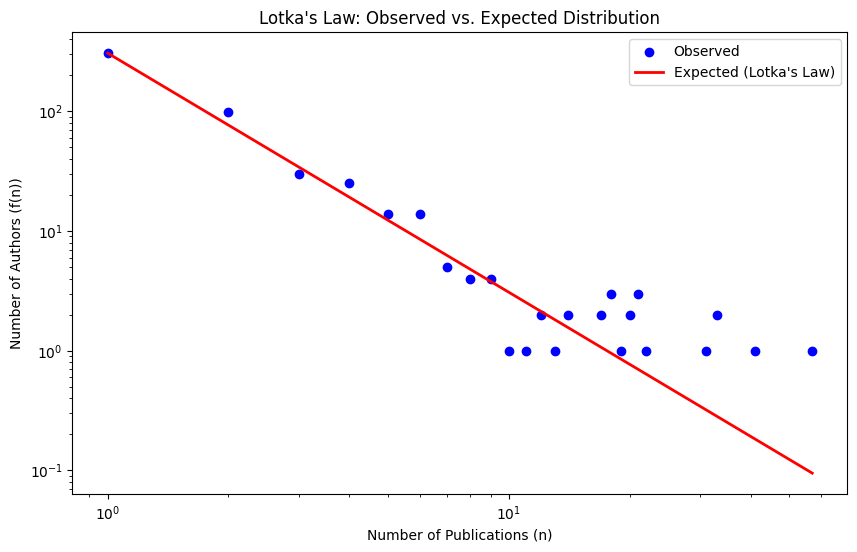

In [134]:
plt.figure(figsize=(10, 6))
plt.scatter(n, observed, color='blue', label='Observed')
plt.plot(n, expected, color='red', label='Expected (Lotka\'s Law)', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Publications (n)')
plt.ylabel('Number of Authors (f(n))')
plt.title('Lotka\'s Law: Observed vs. Expected Distribution')
plt.legend()
plt.savefig('../images/lotkas_law.png', dpi=300)  # Save the figure as a PNG file with 300 dpi

plt.show()

Calculating best minimal value for power law fit
Estimated power law exponent (alpha): 2.6204862975215457
Estimated minimum value for the power law (xmin): 4.0


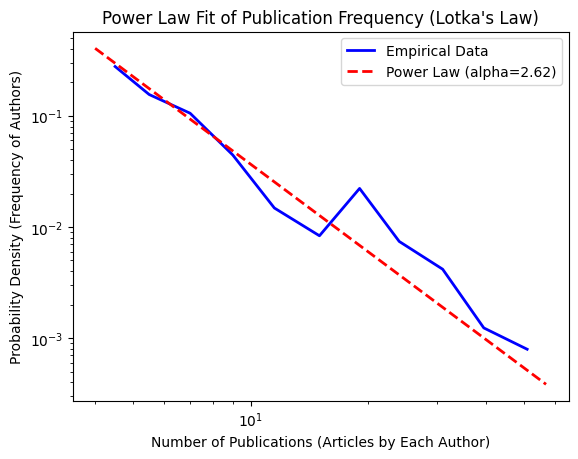

In [135]:
# Assuming `n` contains the number of publications and `observed` contains the frequency

# Repeat each value in `n` according to its frequency in `observed`
data = np.repeat(n, observed)

# Fit the power law to the data
fit = powerlaw.Fit(data)

# Get the estimated alpha (exponent of the power law)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin

print(f"Estimated power law exponent (alpha): {alpha}")
print(f"Estimated minimum value for the power law (xmin): {xmin}")

# Optionally, you can also plot the data and the fitted power law

fig = fit.plot_pdf(color='b', linestyle='-', linewidth=2, label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', linewidth=2, ax=fig, label=f'Power Law (alpha={alpha:.2f})')


# Add titles and labels
plt.title('Power Law Fit of Publication Frequency (Lotka\'s Law)')
plt.xlabel('Number of Publications (Articles by Each Author)')
plt.ylabel('Probability Density (Frequency of Authors)')
plt.legend()
plt.savefig('../images/law_estimated_by_powerlaw.png', dpi=300)  # Save the figure as a PNG file with 300 dpi

plt.show()